In [1]:
Sys.setenv("OMP_NUM_THREADS" = 32)
Sys.setenv("OPENBLAS_NUM_THREADS" = 32)
Sys.setenv("MKL_NUM_THREADS" = 32)
Sys.setenv("VECLIB_MAXIMUM_THREADS" = 32)
Sys.setenv("NUMEXPR_NUM_THREADS" = 32)

library(Seurat)
library(SeuratObject)
library(DESeq2)
library(ggplot2)
library(scales)
library(qs)
library(dplyr)


Loading required package: SeuratObject

Loading required package: sp

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname,

# Merge 3 subsets

In [2]:
path_data = ''

ROSMAP <- read.csv(paste0(path_data, 'ROSMAP_clinical.csv'))
rownames(ROSMAP) <- ROSMAP$projid

data_list <- list()
for(exneuset in c(1:3)){
    data <- readRDS(paste0(path_data, 'Excitatory_neurons_set', exneuset,'.rds'))
    data[['RNA']]$data <- NULL
    cat(dim(data[['RNA']]$counts), '\n')
    if(exneuset==3){
        data <- subset(data, subset = (cell_type_high_resolution != 'Exc RELN CHD7') & (cell_type_high_resolution != 'Exc NRGN'))
        cat(dim(data[['RNA']]$counts), '\n')
    }    
    meta <- ROSMAP[match(data@meta.data$projid, ROSMAP$projid),]
    data@meta.data <- cbind(data@meta.data, meta[,-1])

    data_list[[exneuset]] <- data
}

Warning message:
“Resetting the data matrix to the raw counts”


33538 296936 


Warning message:
“Resetting the data matrix to the raw counts”


33538 421529 


Warning message:
“Resetting the data matrix to the raw counts”


33538 324765 
33538 176219 


In [3]:
# Extract metadata from the first three elements of the list
metadata1 <- data_list[[1]]@meta.data
metadata2 <- data_list[[2]]@meta.data
metadata3 <- data_list[[3]]@meta.data

# Add a column to indicate the source
metadata1$source <- 1
metadata2$source <- 2
metadata3$source <- 3

# Concatenate the metadata
combined_metadata <- rbind(metadata1, metadata2, metadata3)

In [5]:
length(unique(combined_metadata$cell_type_high_resolution))

[1] 12

In [6]:
set.seed(0)

# Initialize an empty vector to store subsampled indices
subsampled_indices <- c()

# Loop through each unique donor_id and sample 300 cells
for (donor in unique(combined_metadata$projid)) {
  donor_indices <- which(combined_metadata$projid == donor)
  if (length(donor_indices) > 300) {
    sampled_indices <- sample(donor_indices, 300, replace = FALSE)
  } else {
    sampled_indices <- donor_indices
  }
  subsampled_indices <- c(subsampled_indices, sampled_indices)
}

# Convert the vector to a numeric vector (if needed)
subsampled_indices <- as.numeric(subsampled_indices)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine




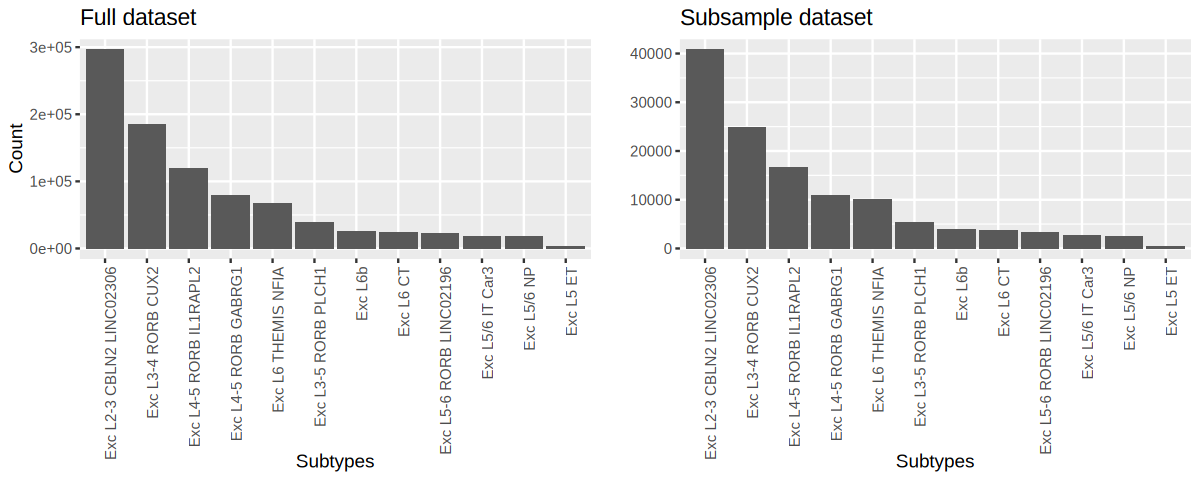

In [7]:
library(ggplot2)
library(gridExtra)
library(repr)

# Set the figure size
options(repr.plot.width = 10, repr.plot.height = 4)

# Full dataset plot
p1 <- ggplot(combined_metadata, aes(x = factor(cell_type_high_resolution, levels = names(sort(table(cell_type_high_resolution), decreasing = TRUE))))) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab('Subtypes') +
  ylab('Count') +
  ggtitle('Full dataset')

# Subsampled dataset plot
p2 <- ggplot(combined_metadata[subsampled_indices, ], aes(x = factor(cell_type_high_resolution, levels = names(sort(table(cell_type_high_resolution), decreasing = TRUE))))) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab('Subtypes') +
  ylab('') +
  ggtitle('Subsample dataset')

# Arrange the plots side by side
grid.arrange(p1, p2, ncol = 2, widths = c(8, 8), heights = c(4))

In [8]:
# Initialize an empty list to store subsetted Seurat objects
subsetted_seurat_list <- list()

# Loop through each Seurat object and subset using subsampled_indices
for (i in 1:length(data_list)) {
  subsetted_seurat <- subset(data_list[[i]], cells = rownames(combined_metadata[subsampled_indices, ][combined_metadata[subsampled_indices, ]$source==i,]))
  subsetted_seurat_list[[i]] <- subsetted_seurat
}

# Merge the subsetted Seurat objects into a single Seurat object
data_subsample <- Reduce(function(x, y) merge(x, y), subsetted_seurat_list)

# Now merged_seurat contains the merged data from the subsetted Seurat objects

In [9]:
data_subsample

An object of class Seurat 
33538 features across 124997 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [10]:
saveRDS(data_subsample, paste0(path_data, "exneu_sc_subsample.rds"))

# Pseudobulk

In [11]:
set_meta_pb <- function(data, metadata, ind_name, cov_names){
    metadata[,ind_name] <- gsub(metadata[,c(ind_name)], pattern = "_", replacement = "-")
    metadata$index <- as.character(metadata[,ind_name])
    
    metadata <- metadata[!duplicated(metadata$index),][,c('index',cov_names)]
    rownames(metadata) <- metadata$index
    metadata <- metadata[data@meta.data$orig.ident,]
    
    data@meta.data[,cov_names] <- metadata[,cov_names]
    data
}

In [12]:
pb <- AggregateExpression(data_subsample, assays = "RNA", return.seurat = T, group.by = c("projid"))
pb@meta.data$projid <- gsub(pb@meta.data$projid,  pattern = "g", replacement = "")
pb@meta.data$orig.ident <- pb@meta.data$projid

pb <- set_meta_pb(pb, data_subsample@meta.data, "projid", c('age_first_ad_dx', 'msex', 'pmi', 'age_death', 'age_at_visit_max'))
pb[['RNA']]$data <- NULL
pb[['RNA']]$scale.data <- NULL

First group.by variable `projid` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Centering and scaling data matrix



In [14]:
pb <- pb[rowSums(pb[['RNA']]$counts>0) >= 0,]
dim(pb)

[1] 33538   427

In [15]:
pb <- pb[rowSums(pb[['RNA']]$counts>1) >= 10,]
dim(pb)

[1] 26106   427

In [16]:
saveRDS(pb, paste0(path_data, "exneu_pb.rds"))